# 遗传算法介绍

遗传算法是一种模拟自然进化过程来解决优化问题的方法。在本案例中，算法被用来优化工作排班，以确保满足货物处理需求的同时，考虑到工人的工作条件。

## 1. 初始化
- **种群初始化**：算法首先生成一组随机排班（染色体），每个染色体代表一种可能的工人排班方案。

## 2. 适应度函数（目标函数）
- **适应度计算**：
  - **基本效率**：每个常规工人对适应度的贡献为1分，每个临时工人贡献0.8分。
  - **基本适应度**：`基本适应度 = 1 × 常规工人数 + 0.8 × 临时工人数`
  - **货物需求满足度**：
    - 若货物处理量未满足需求，则适应度受到重罚：`货物处理量 = 25 × 常规工人数 + 20 × 临时工人数`
    - 罚分：`罚分 = 10 × (需求量 − 货物处理量)`
    - 若货物处理量满足或超过需求，则适应度获得奖励：`奖励 = 需求量`
  - **工作连续性约束**：若工人连续工作天数超过7天，进行适应度扣分：`连续工作罚分 = 20 × 工作天数`
  - **工作出勤率约束**：若工人的出勤率超过85%，进行适应度扣分：`出勤率罚分 = 5 × 工作天数`

## 3. 遗传操作
- **选择操作**：选择适应度最高的一半染色体，进入下一代种群。
- **交叉操作**：从两个父代染色体中随机选择一个交叉点，结合它们的部分遗传信息，生成新的染色体。
- **变异操作**：随机选择某个染色体的一部分，对其进行修改以增加遗传多样性。

## 4. 约束条件
- **工人每天只能分配到一个班次**：确保每个工人每天的班次安排不会重复。
- **货物处理量需求**：每个班次的货物处理量需满足特定的需求量。

## 5. 目标
- **优化目标**：最大化适应度函数

In [38]:
import pandas as pd
import random
from collections import defaultdict

data = pd.read_csv('结果4.csv')

# 过滤特定分拣中心
sc60_data = data[data['分拣中心'] == 'SC60']

# 定义班次时间范围
shifts = {
    "00:00-08:00": range(0, 8),
    "05:00-13:00": range(5, 13),
    "08:00-16:00": range(8, 16),
    "12:00-20:00": range(12, 20),
    "14:00-22:00": range(14, 22),
    "16:00-24:00": range(16, 24)
}

# 按日期和班次整理每小时数据
shift_data = {}
for shift, hours in shifts.items():
    mask = sc60_data['小时'].isin(hours)
    grouped = sc60_data.loc[mask].groupby('日期')['货量'].sum()
    shift_data[shift] = grouped.to_dict()
shift_data 

{'00:00-08:00': {'2023/12/01': 22219.0,
  '2023/12/02': 22437.0,
  '2023/12/03': 22613.0,
  '2023/12/04': 22754.0,
  '2023/12/05': 22869.0,
  '2023/12/06': 22962.0,
  '2023/12/07': 23040.0,
  '2023/12/08': 23099.0,
  '2023/12/09': 23148.0,
  '2023/12/10': 23189.0,
  '2023/12/11': 23223.0,
  '2023/12/12': 23248.0,
  '2023/12/13': 23270.0,
  '2023/12/14': 23288.0,
  '2023/12/15': 23300.0,
  '2023/12/16': 23311.0,
  '2023/12/17': 23320.0,
  '2023/12/18': 23329.0,
  '2023/12/19': 23333.0,
  '2023/12/20': 23339.0,
  '2023/12/21': 23344.0,
  '2023/12/22': 23345.0,
  '2023/12/23': 23349.0,
  '2023/12/24': 23350.0,
  '2023/12/25': 23352.0,
  '2023/12/26': 23353.0,
  '2023/12/27': 23354.0,
  '2023/12/28': 23357.0,
  '2023/12/29': 23357.0,
  '2023/12/30': 23358.0},
 '05:00-13:00': {'2023/12/01': 11635.0,
  '2023/12/02': 13865.0,
  '2023/12/03': 15674.0,
  '2023/12/04': 17135.0,
  '2023/12/05': 18320.0,
  '2023/12/06': 19281.0,
  '2023/12/07': 20057.0,
  '2023/12/08': 20686.0,
  '2023/12/09': 211

In [39]:
# 遗传算法参数
num_generations = 30
population_size = 50
num_workers = 200
num_shifts = 6
dates = sorted(sc60_data['日期'].unique())

In [40]:
def create_chromosome():
    chromosome = {}
    for date in dates:
        workers_daily_schedule = {worker: None for worker in range(num_workers)}  # 追踪每个工人这一天的班次
        for shift_key in shifts.keys():
            # 确保每个工人每天只能被分配到一个班次
            available_workers = [w for w, s in workers_daily_schedule.items() if s is None]
            num_regulars = random.randint(1, min(10, len(available_workers)))
            regulars = random.sample(available_workers, k=num_regulars)
            for reg in regulars:
                workers_daily_schedule[reg] = shift_key  # 标记此工人已被分配到班次
            
            chromosome[(date, shift_key)] = {
                'regulars': regulars,
                'temps': random.randint(1, 5)
            }
    return chromosome


## 目标函数（适应度函数）

$$
\text{fitness}(chromosome) = \sum_{\text{所有班次}} \left( \text{基础适应度} + \text{需求满足奖励} - \text{货物不足罚分} - \text{连续工作罚分} - \text{出勤率罚分} \right)
$$


每个染色体的适应度是通过计算每一天每一个班次的这些值的总和来评估的。最终，适应度函数提供了一个量化的评分，说明了某个特定排班方案在满足货物处理需求、管理工人工作负荷等方面的效果。遗传算法通过不断选择高适应度的染色体，进行交叉和变异，以迭代地寻求适应度函数值最大的最优解。


In [41]:
def calculate_fitness(chromosome):
    fitness = 0
    worker_days = defaultdict(int)
    for (day, shift_key), info in chromosome.items():
        # 计算每位工人的出勤天数
        for worker in info['regulars']:
            worker_days[worker] += 1

        # 基础效率评估
        fitness += len(info['regulars']) * 1 + info['temps'] * 0.8
        
        # 检查班次的货物需求是否得到满足
        required_output = shift_data[shift_key].get(day, 0)  # 使用与 shift_data 键匹配的 shift_key
        cargo_met = 25 * len(info['regulars']) + 20 * info['temps']
        if cargo_met < required_output:
            deficit = required_output - cargo_met
            # 未满足要求时给予重罚
            fitness -= deficit * 10  
        else:
            # 通过满足需求来确保100%的需求完成，对此进行奖励
            fitness += required_output
        
    # 对连续工作超过7天的工人进行惩罚
    for worker, days in worker_days.items():
        if days > 7:
            fitness -= 20 * days  # 对连续工作超过7天的工人进行严厉的惩罚

    # 确保没有工人的出勤率超过85%
    for worker, days in worker_days.items():
        if days / 30 > 0.85:
            fitness -= 5 * days  # 对超过85%出勤率的工人进行惩罚

    return fitness


In [42]:
# 选择
def select(population):
    sorted_population = sorted(population, key=calculate_fitness, reverse=True)
    return sorted_population[:len(population)//2]

# 交叉
def crossover(chromosome1, chromosome2):
    child = chromosome1.copy()
    crossover_point = random.randint(0, len(chromosome1))
    crossover_keys = list(chromosome1.keys())[crossover_point:]
    for key in crossover_keys:
        child[key] = chromosome2[key]
    return child

# 变异
def mutate(chromosome):
    mutation_key = random.choice(list(chromosome.keys()))
    chromosome[mutation_key]['regulars'] = random.sample(range(num_workers), k=random.randint(1, 10))
    chromosome[mutation_key]['temps'] = random.randint(1, 5)
    return chromosome


In [43]:
# 遗传算法主逻辑
def genetic_algorithm():
    population = [create_chromosome() for _ in range(population_size)]
    for generation in range(num_generations):
        population = select(population)
        new_generation = []
        while len(new_generation) < population_size:
            parent1, parent2 = random.sample(population, 2)
            child = crossover(parent1, parent2)
            if random.random() < 0.04:
                child = mutate(child)
            new_generation.append(child)
        population = new_generation
    return max(population, key=calculate_fitness)  # 返回适应度最高的染色体

genetic_algorithm()


{('2023/12/01', '00:00-08:00'): {'regulars': [199, 80, 93, 149], 'temps': 3},
 ('2023/12/01',
  '05:00-13:00'): {'regulars': [31,
   38,
   76,
   162,
   195,
   171,
   104,
   25,
   5,
   52], 'temps': 2},
 ('2023/12/01',
  '08:00-16:00'): {'regulars': [105,
   48,
   24,
   112,
   133,
   14,
   83,
   161,
   59], 'temps': 3},
 ('2023/12/01',
  '12:00-20:00'): {'regulars': [189,
   116,
   109,
   172,
   99,
   137,
   77,
   60,
   43,
   111], 'temps': 3},
 ('2023/12/01',
  '14:00-22:00'): {'regulars': [57,
   17,
   3,
   2,
   34,
   129,
   16,
   40,
   20,
   49], 'temps': 3},
 ('2023/12/01',
  '16:00-24:00'): {'regulars': [193, 23, 65, 173, 13, 55, 44, 51], 'temps': 2},
 ('2023/12/02',
  '00:00-08:00'): {'regulars': [117, 61, 93, 162, 72, 31, 145, 87, 127],
  'temps': 2},
 ('2023/12/02',
  '05:00-13:00'): {'regulars': [78,
   83,
   134,
   68,
   60,
   52,
   35,
   96,
   34,
   30], 'temps': 4},
 ('2023/12/02',
  '08:00-16:00'): {'regulars': [194, 86, 27, 60, 99, 16

In [44]:
best_chromosome = genetic_algorithm()

results_df = pd.DataFrame([
    {'分拣中心': 'SC60', '日期': key[0], '班次': key[1], '出勤员工': f'正式工{worker}'}
    for key, value in best_chromosome.items() for worker in value['regulars']
] + [
    {'分拣中心': 'SC60', '日期': key[0], '班次': key[1], '出勤员工': f'临时工{value["temps"]}人'}
    for key, value in best_chromosome.items() if value['temps'] > 0
])

results_df.head(20)


,分拣中心,日期,班次,出勤员工
0,SC60,2023/12/01,00:00-08:00,正式工193
1,SC60,2023/12/01,00:00-08:00,正式工176
2,SC60,2023/12/01,00:00-08:00,正式工123
3,SC60,2023/12/01,00:00-08:00,正式工44
4,SC60,2023/12/01,00:00-08:00,正式工90
5,SC60,2023/12/01,00:00-08:00,正式工156
6,SC60,2023/12/01,05:00-13:00,正式工100
7,SC60,2023/12/01,05:00-13:00,正式工11
8,SC60,2023/12/01,05:00-13:00,正式工183
9,SC60,2023/12/01,05:00-13:00,正式工20


In [45]:
import pandas as pd

best_chromosome = genetic_algorithm()

columns = ['分拣中心', '日期', '班次', '出勤员工']
results_df = pd.DataFrame(columns=columns)

rows = [] 
for (date, shift), value in best_chromosome.items(): 
    for worker in value['regulars']:
        rows.append({
            '分拣中心': 'SC60',
            '日期': date,
            '班次': shift,  # 直接使用 shift，因为它已是班次描述
            '出勤员工': f'正式工{worker}'
        })
    # 添加临时工的出勤记录
    if value['temps'] > 0:
        rows.append({
            '分拣中心': 'SC60',
            '日期': date,
            '班次': shift,  # 直接使用 shift
            '出勤员工': f'临时工{value["temps"]}人'
        })

results_df = pd.concat([results_df, pd.DataFrame(rows)], ignore_index=True)

results_df.head(20)


,分拣中心,日期,班次,出勤员工
0,SC60,2023/12/01,00:00-08:00,正式工168
1,SC60,2023/12/01,00:00-08:00,正式工47
2,SC60,2023/12/01,00:00-08:00,临时工1人
3,SC60,2023/12/01,05:00-13:00,正式工74
4,SC60,2023/12/01,05:00-13:00,正式工144
5,SC60,2023/12/01,05:00-13:00,正式工198
6,SC60,2023/12/01,05:00-13:00,正式工183
7,SC60,2023/12/01,05:00-13:00,正式工179
8,SC60,2023/12/01,05:00-13:00,正式工84
9,SC60,2023/12/01,05:00-13:00,正式工181


In [46]:
results_df = pd.concat([results_df, pd.DataFrame(rows)], ignore_index=True)

results_df.to_csv('结果6.csv', index=False, encoding='utf-8-sig')

print("数据已经成功保存到结果6.csv文件中。")

数据已经成功保存到结果6.csv文件中。


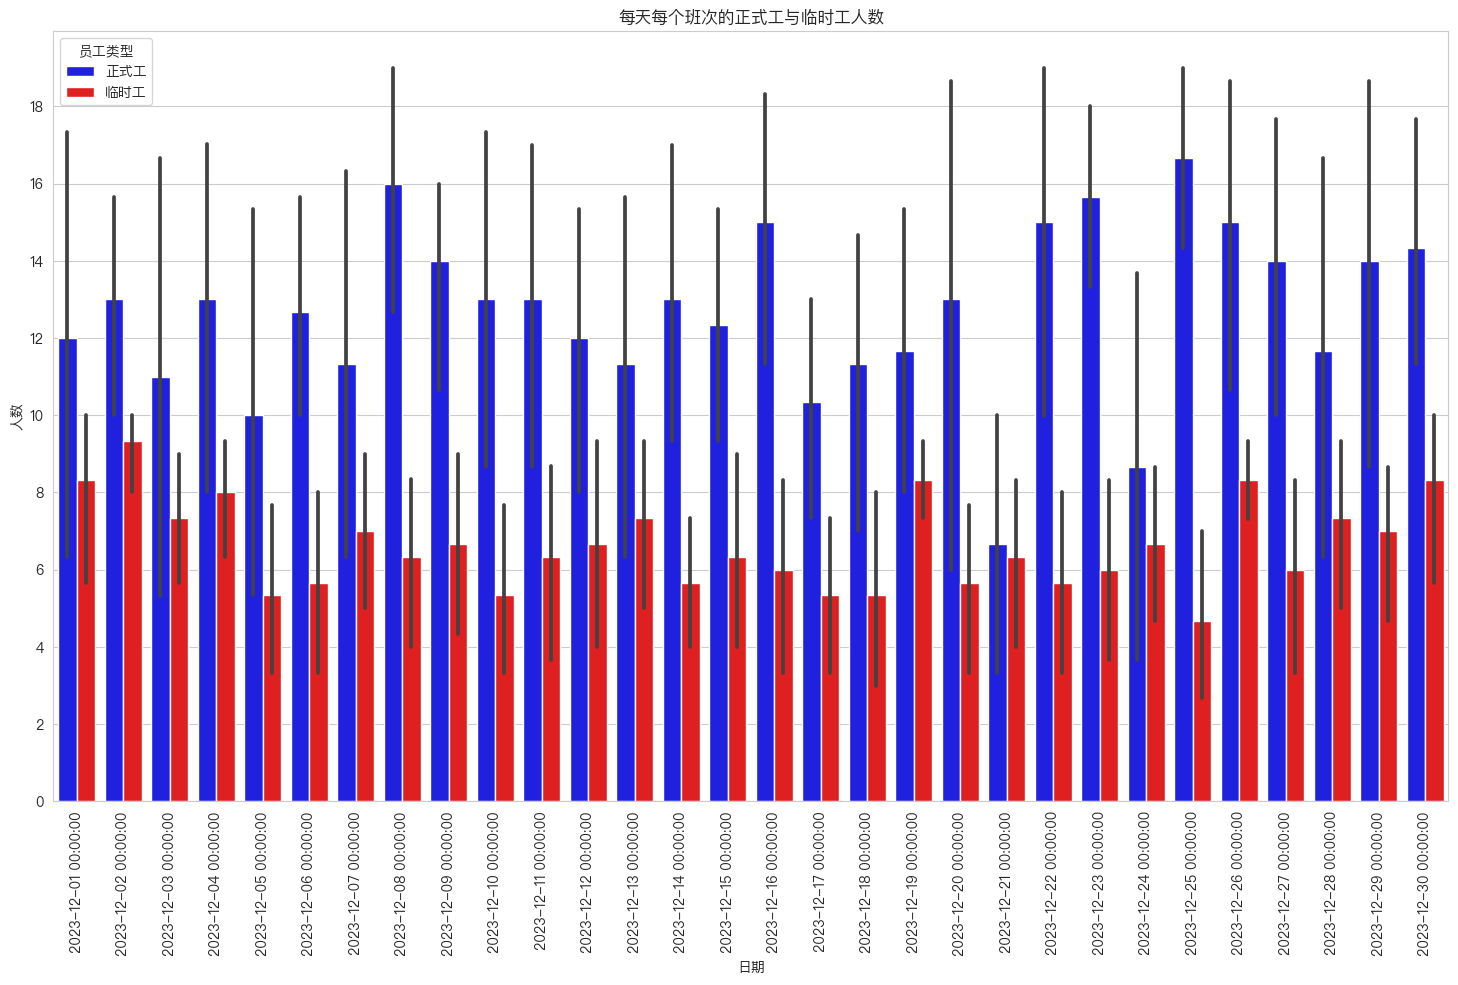

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

font_path = '/System/Library/Fonts/PingFang.ttc'
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_csv('结果6.csv')

data['日期'] = pd.to_datetime(data['日期'])

data['是否正式工'] = data['出勤员工'].str.contains('正式工')

data['临时工人数'] = data['出勤员工'].str.extract('临时工(\d+)人').fillna(0).astype(int)

grouped = data.groupby(['日期', '班次'])
regulars_count = grouped['是否正式工'].sum().unstack(fill_value=0)

temp_count = grouped['临时工人数'].sum().unstack(fill_value=0)

summary_df = pd.DataFrame({
    '正式工': regulars_count.stack(),
    '临时工': temp_count.stack()
}).reset_index()

# 数据转换
summary_df_melt = summary_df.melt(id_vars=['日期', '班次'], var_name='员工类型', value_name='人数')

plt.figure(figsize=(18, 10))
sns.barplot(data=summary_df_melt, x='日期', y='人数', hue='员工类型', palette={'正式工': 'blue', '临时工': 'red'})
plt.title('每天每个班次的正式工与临时工人数')
plt.xlabel('日期')
plt.ylabel('人数')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(title='员工类型')
plt.show()



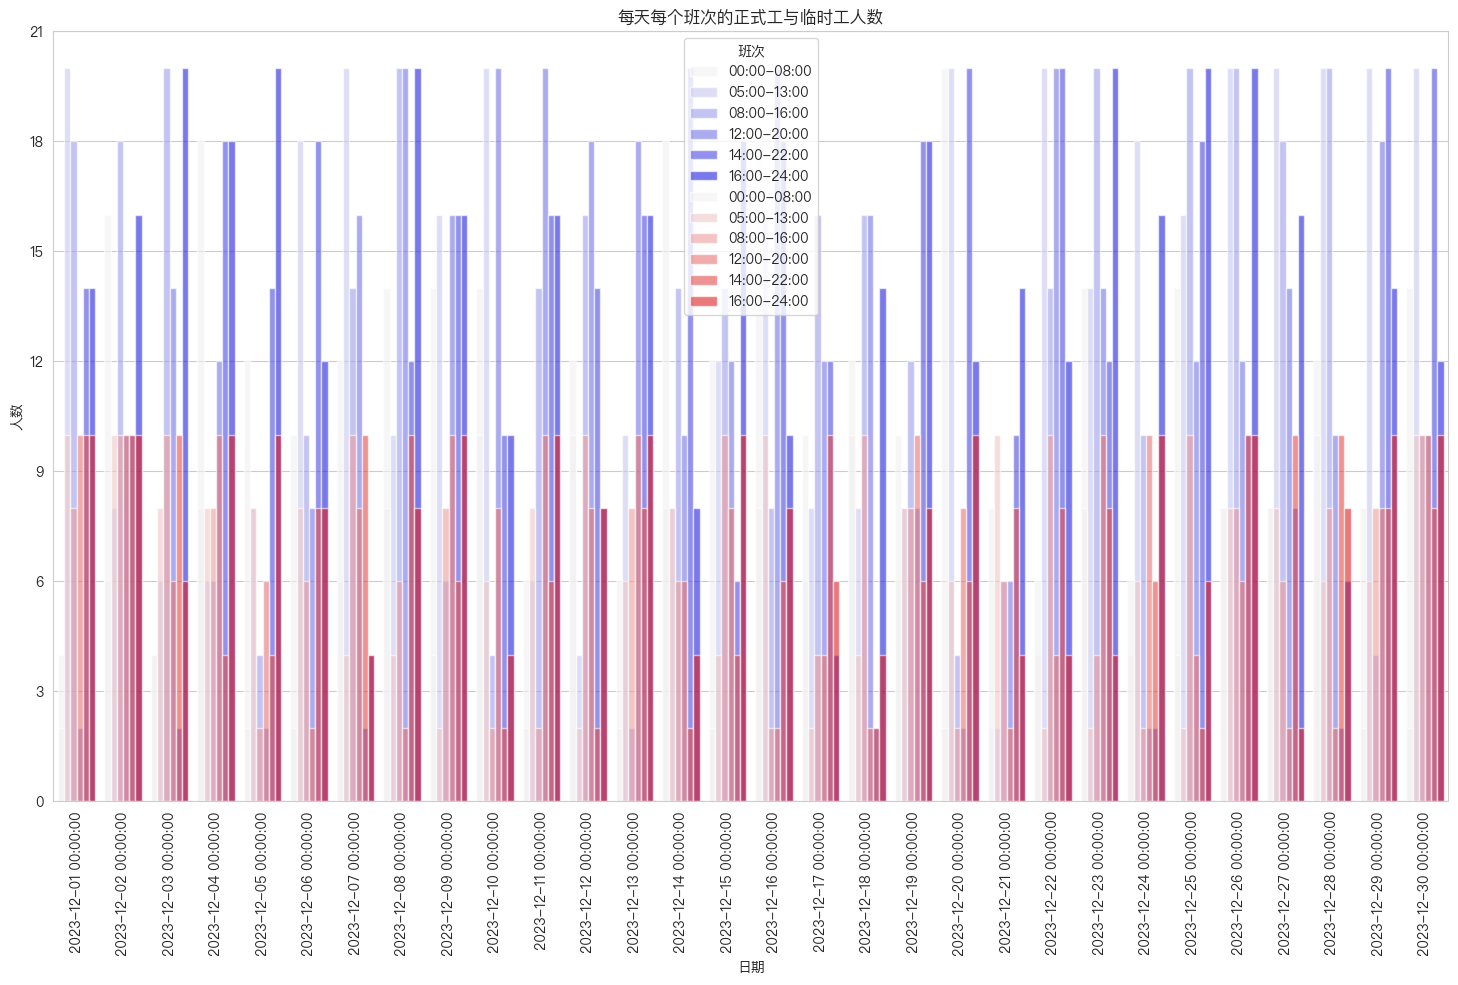

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

font_path = '/System/Library/Fonts/PingFang.ttc'
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_csv('结果6.csv')

data['日期'] = pd.to_datetime(data['日期'])

data['是否正式工'] = data['出勤员工'].str.contains('正式工')

data['临时工人数'] = data['出勤员工'].str.extract('临时工(\d+)人').fillna(0).astype(int)

grouped = data.groupby(['日期', '班次'])
regulars_count = grouped['是否正式工'].sum().unstack(fill_value=0)

temp_count = grouped['临时工人数'].sum().unstack(fill_value=0)

summary_df = pd.DataFrame({
    '正式工': regulars_count.stack(),
    '临时工': temp_count.stack()
}).reset_index()

plt.figure(figsize=(18, 10))
sns.barplot(data=summary_df, x='日期', hue='班次', y='正式工', color='blue', alpha=0.6)
sns.barplot(data=summary_df, x='日期', hue='班次', y='临时工', color='red', alpha=0.6)
plt.title('每天每个班次的正式工与临时工人数')
plt.xlabel('日期')
plt.ylabel('人数')
plt.xticks(rotation=90) 
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))  
plt.legend(title='班次')
plt.show()

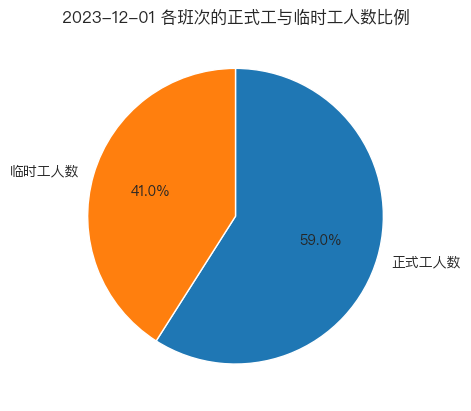

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('结果6.csv')
font_path = '/System/Library/Fonts/PingFang.ttc'
plt.rcParams['font.sans-serif'] = ['PingFang HK'] 
plt.rcParams['axes.unicode_minus'] = False  

data['日期'] = pd.to_datetime(data['日期'])

data['是否正式工'] = data['出勤员工'].str.contains('正式工')
data['是否临时工'] = data['出勤员工'].str.contains('临时工')
data['临时工人数'] = data['出勤员工'].str.extract('临时工(\d+)人').fillna(0).astype(int)

date_of_interest = '2023-12-01'
filtered_data = data[data['日期'] == pd.Timestamp(date_of_interest)]

grouped = filtered_data.groupby(['班次']).agg({'是否正式工':'sum', '临时工人数':'sum'})

grouped.columns = ['正式工人数', '临时工人数']  # 确保列名正确
pie_data = grouped.sum()

fig, ax = plt.subplots()
pie_data.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, counterclock=False, labels=pie_data.index)
ax.set_ylabel('') 
ax.set_title(f'{date_of_interest} 各班次的正式工与临时工人数比例')

# 显示图表
plt.show()


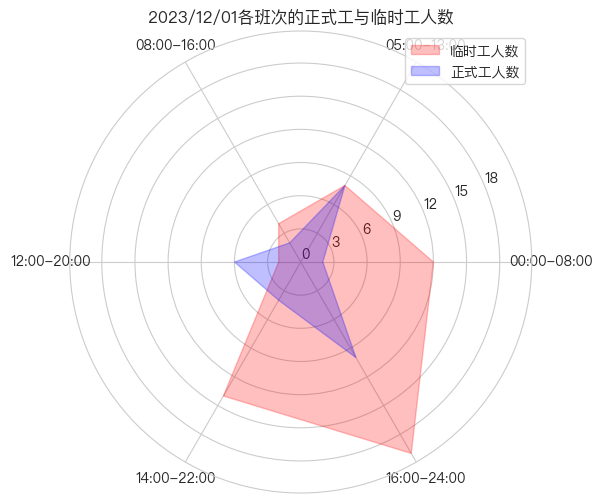

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

data = pd.read_csv('结果6.csv')

data['日期'] = pd.to_datetime(data['日期'])

data['是否正式工'] = data['出勤员工'].str.contains('正式工')
data['临时工人数'] = data['出勤员工'].str.extract('临时工(\d+)人').fillna(0).astype(int)

date_of_interest = '2023-12-5'
filtered_data = data[data['日期'] == pd.Timestamp(date_of_interest)]

grouped = filtered_data.groupby('班次').agg({
    '是否正式工': 'sum',  
    '临时工人数': 'sum'  
})

labels = np.array(grouped.index)
stats = grouped.values

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
stats = np.concatenate((stats, [stats[0]])) 
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats[:, 0], color='red', alpha=0.25, label='临时工人数')
ax.fill(angles, stats[:, 1], color='blue', alpha=0.25, label='正式工人数')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # 设置Y轴刻度仅显示整数

plt.title('2023/12/01各班次的正式工与临时工人数')
plt.legend(loc='upper right')
plt.show()
